This work is part of my bachelor's thesis to identify euribor 12 month interest rates, diesel prices and bankruptcies effects on road freight transportation companies payment delays. In order to find the best model, different explanatory variables are explored. The Gauss-Markow time series assumptions are tested to identify a valid and unbiased model.

Hypothesis 1

- H0: An increase in diesel prices may lead to an increase in payment delays.
- H1: An increase in diesel prices may lead to a decrease in payment delays.

Hypothesis 2

- H0: An increase in Euribor's 12-month interest rates may lead to an increase in payment delays.
- H1: An increase in Euribor's 12-month interest rates may lead to a decrease in payment delays.

Hypothesis 3

- H0: An increase in bankruptcies within the transportation and warehousing industry may lead to an increase in payment delays.
- H1: An increase in bankruptcies within the transportation and warehousing industry may lead to a decrease in payment delays.

# Loading packages

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro
from scipy.stats import norm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import durbin_watson
import statsmodels.tsa.stattools as tsa
from statsmodels.tsa.stattools import adfuller


import warnings
warnings.filterwarnings('ignore')

# Loading data

In [54]:
file = pd.read_excel('average_delay_15-22.xlsx')
file.columns = ['Date', 'Diesel', 'Diesel_p', 'Delay', 'Delay_p', '12-month', 'Import', 'Export', 'Bankruptcy', 'Bankruptcy2']
print(file.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         92 non-null     object 
 1   Diesel       92 non-null     float64
 2   Diesel_p     92 non-null     float64
 3   Delay        92 non-null     float64
 4   Delay_p      92 non-null     float64
 5   12-month     92 non-null     float64
 6   Import       92 non-null     int64  
 7   Export       92 non-null     int64  
 8   Bankruptcy   92 non-null     int64  
 9   Bankruptcy2  92 non-null     int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 7.3+ KB
None


#####  Variable explanations
- Date (date respective the invoice is by it's duedate)
- Diesel (average monthly price)
- Diesel_p (percentage change)
- Delay (average monthly payment delays)
- Delay_p (percentage change)
- 12-month (euribor 12 month monthly average rates)
- Import (monthly imports from Russia)
- Export (monthly exports to Russia)
- Bankruptcy (monthly average bankruptcies in transportation and logistics in Finland)

In [55]:
file.describe()

,Diesel,Diesel_p,Delay,Delay_p,12-month,Import,Export,Bankruptcy,Bankruptcy2
count,92.000000,92.000000,92.000000,92.000000,92.000000,9.200000e+01,9.200000e+01,92.000000,92.000000
mean,1.415761,0.006167,6.020310,0.043610,-0.130155,6.338927e+08,2.224102e+08,202.456522,15.086957
std,0.264962,0.041827,3.408130,0.388713,0.298678,1.786186e+08,4.467623e+07,43.538391,5.739112
min,1.130000,-0.079295,1.250829,-0.691183,-0.504429,3.179626e+08,5.982596e+07,90.000000,2.000000
25%,1.257500,-0.014733,3.686893,-0.209124,-0.284503,5.131820e+08,2.095813e+08,175.000000,11.000000
50%,1.360000,0.000000,5.390953,0.010139,-0.153961,6.383252e+08,2.325175e+08,208.000000,15.000000
75%,1.440000,0.026708,8.015145,0.270892,-0.043228,7.437369e+08,2.513367e+08,230.250000,19.000000
max,2.440000,0.245989,20.067550,1.015917,1.249478,1.107008e+09,2.962454e+08,296.000000,29.000000


# Checking for seasonality and trends

- Visualisation of average monthly payment delays in days
- Visualisation of average monthly diesel prices and euribor 12 month interest rates

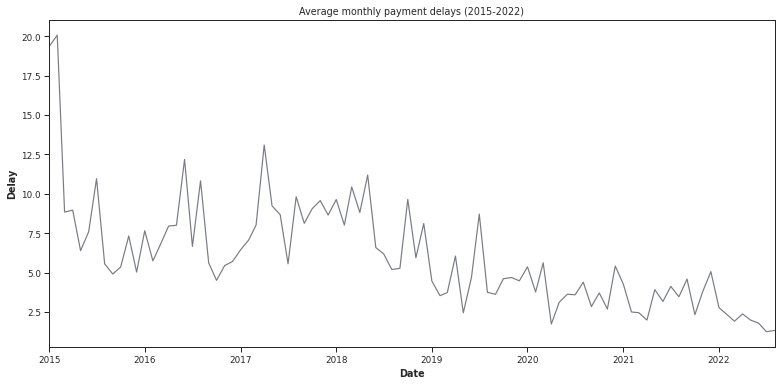

In [56]:
sns.set_context("paper")
file['Date'] = pd.to_datetime(file['Date'], format='%YM%m')
file['Delay'] = file['Delay'].astype(float)
sns.set_style('ticks')
sns.set_palette('deep', desat=.1)
plt.figure(figsize=(13, 6))
sns.lineplot(x='Date', y='Delay', data=file)

plt.xlabel('Date', weight='bold')
plt.ylabel('Delay', weight='bold')
plt.title('Average monthly payment delays (2015-2022)')

plt.xlim([datetime.date(2015, 1, 1), datetime.date(2022, 8, 1)])
plt.show()


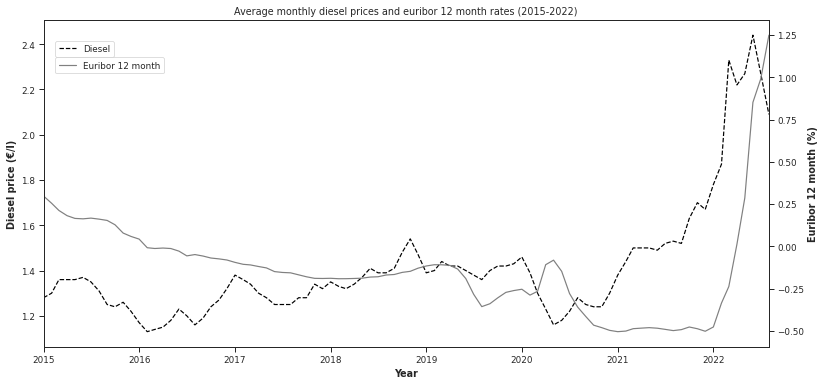

In [57]:
sns.set_context("paper")
file['Diesel'] = file['Diesel'].astype(float)
file['12kk'] = file['12-month'].astype(float)
sns.set_style(("ticks"))
sns.set_palette("deep", desat=.1)
plt.figure(figsize=(13,6))
ax = sns.lineplot(x="Date", y="Diesel", data=file, color='black', linestyle='--')
ax2 = ax.twinx()
ax2 = sns.lineplot(x="Date", y="12-month", data=file, color='grey')

ax.set_ylabel('Diesel price (€/l)', weight='bold')
ax2.set_ylabel('Euribor 12 month (%)', weight='bold')
ax.set_xlabel('Year', weight='bold')

# Set legends and location
ax.legend(['Diesel'], loc='upper left', bbox_to_anchor=(0.01, 0.95))
ax2.legend(['Euribor 12 month'], loc='upper left', bbox_to_anchor=(0.01, 0.9))

ax.set_xlim([datetime.date(2015, 1, 1), datetime.date(2022, 8, 1)])
plt.title('Average monthly diesel prices and euribor 12 month rates (2015-2022)')
plt.show()


As there is no seasonality/trends detected, the time series regression model is suitable for this data.

# Model 1

## Correlation test for multicollinearity

Correlation heatmap of the variables

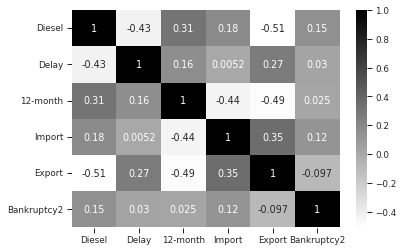

In [58]:
corr = file[['Date', 'Diesel', 'Delay', '12-month', 'Import', 'Export', 'Bankruptcy2' ]].corr()
sns.heatmap(corr, annot=True, cmap='gray_r')
plt.show()

Checking Variance inflation factor to detect multicollinearity

In [59]:
vif = pd.DataFrame()
X = file[['Diesel', '12-month', 'Import', 'Export', 'Bankruptcy2']]
X['intercept'] = 1
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif = vif[vif['features']!='intercept']
print(vif)

   VIF Factor     features
0    1.835003       Diesel
1    1.600443     12-month
2    1.759411       Import
3    1.949991       Export
4    1.041079  Bankruptcy2


## Shapiro test for normality

In [61]:
y = file['Delay']
x = file[['Diesel', '12-month', 'Import', 'Export', 'Bankruptcy2']]
x = sm.add_constant(x)
model1 = sm.OLS(y, x).fit()
residuals1 = model1.resid

stat, p = shapiro(residuals1)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.909, p=0.000
Sample does not look Gaussian (reject H0)


## Breusch-Pagan test for heteroscedasticity

In [63]:
bp_test = het_breuschpagan(model1.resid, model1.model.exog)
print(bp_test)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
for i in range(len(bp_test)):
    print(labels[i] + ': ' + str(bp_test[i]))
alpha = 0.05
if bp_test[1] > alpha:
    print('Sample looks homoscedastic (fail to reject H0)')
else:
    print('Sample does not look homoscedastic (reject H0)')

(13.943910738028524, 0.015969655409535516, 3.072601599205881, 0.013386349645454383)
Lagrange multiplier statistic: 13.943910738028524
p-value: 0.015969655409535516
f-value: 3.072601599205881
f p-value: 0.013386349645454383
Sample does not look homoscedastic (reject H0)


The data does not fulfill assumptions of normality or homoscedasticity, therefore some of the variables will be log transfromed.

# Model 2 - Log transformed variables
Euribor 12 month is a percentage and therefore it's left in it's original form.

In [64]:
# log transforming Delays, Diesel, Bankruptcies, Imports and Exports
file['log_delay'] = np.log(file['Delay'])
file['log_diesel'] = np.log(file['Diesel'])
file['log_bankruptcy2'] = np.log(file['Bankruptcy2'])
file['log_import'] = np.log(file['Import'])
file['log_export'] = np.log(file['Export'])
file.describe()

,Diesel,Diesel_p,Delay,Delay_p,12-month,Import,Export,Bankruptcy,Bankruptcy2,12kk,log_delay,log_diesel,log_bankruptcy2,log_import,log_export
count,92.000000,92.000000,92.000000,92.000000,92.000000,9.200000e+01,9.200000e+01,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,1.415761,0.006167,6.020310,0.043610,-0.130155,6.338927e+08,2.224102e+08,202.456522,15.086957,-0.130155,1.644587,0.333598,2.629847,20.227210,19.189777
std,0.264962,0.041827,3.408130,0.388713,0.298678,1.786186e+08,4.467623e+07,43.538391,5.739112,0.298678,0.565090,0.160605,0.443024,0.288697,0.279040
min,1.130000,-0.079295,1.250829,-0.691183,-0.504429,3.179626e+08,5.982596e+07,90.000000,2.000000,-0.504429,0.223806,0.122218,0.693147,19.577444,17.906950
25%,1.257500,-0.014733,3.686893,-0.209124,-0.284503,5.131820e+08,2.095813e+08,175.000000,11.000000,-0.284503,1.304738,0.229120,2.397895,20.056136,19.160622
50%,1.360000,0.000000,5.390953,0.010139,-0.153961,6.383252e+08,2.325175e+08,208.000000,15.000000,-0.153961,1.684713,0.307485,2.708050,20.274324,19.264473
75%,1.440000,0.026708,8.015145,0.270892,-0.043228,7.437369e+08,2.513367e+08,230.250000,19.000000,-0.043228,2.081333,0.364643,2.944439,20.427181,19.342304
max,2.440000,0.245989,20.067550,1.015917,1.249478,1.107008e+09,2.962454e+08,296.000000,29.000000,1.249478,2.999104,0.891998,3.367296,20.824927,19.506699


## Correlation test for multicollinearity

Correlation heatmap

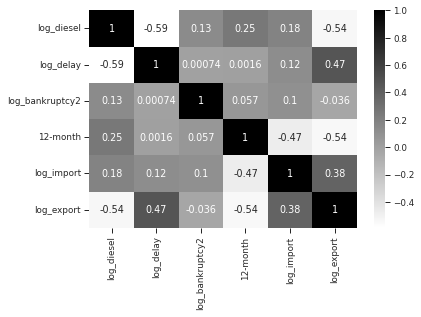

In [65]:
corr = file[['Date', 'log_diesel', 'log_delay', 'log_bankruptcy2', '12-month', 'log_import','log_export']].corr()
sns.heatmap(corr, annot=True, cmap='gray_r')
plt.show()

Checking Variance inflation factor to detect multicollinearity

In [66]:
vif = pd.DataFrame()
X = file[['log_diesel', 'log_bankruptcy2', '12-month', 'log_import','log_export']]
X['intercept'] = 1
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif = vif[vif['features']!='intercept']
print(vif)

   VIF Factor         features
0    1.919200       log_diesel
1    1.032366  log_bankruptcy2
2    1.658914         12-month
3    1.811470       log_import
4    2.278526       log_export


## Shapiro test for normality

In [67]:
y = file['log_delay']
x = file[['log_diesel', 'log_delay', 'log_bankruptcy2', '12-month', 'log_import','log_export']]
x = sm.add_constant(x)
model2 = sm.OLS(y, x).fit()

residuals2 = model2.resid

stat, p = shapiro(residuals2)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.859, p=0.000
Sample does not look Gaussian (reject H0)


## Breusch-Pagan test for heteroscedasticity

In [68]:
bp_test = het_breuschpagan(model2.resid, model2.model.exog)
print(bp_test)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
for i in range(len(bp_test)):
    print(labels[i] + ': ' + str(bp_test[i]))
alpha = 0.05
if bp_test[1] > alpha:
    print('Sample looks homoscedastic (fail to reject H0)')
else:
    print('Sample does not look homoscedastic (reject H0)')

(91.2135146542415, 1.6955266617748016e-17, 1642.9949579741167, 1.2145167059816664e-85)
Lagrange multiplier statistic: 91.2135146542415
p-value: 1.6955266617748016e-17
f-value: 1642.9949579741167
f p-value: 1.2145167059816664e-85
Sample does not look homoscedastic (reject H0)


Model 2 does not fulfill normality assumption or homoscedasticity assimption, therefore another model is tested.

# Model 3 - Testing the model without log_exports

## Shapiro test for normality

In [69]:
y = file['log_delay']
x = file[['log_diesel', '12-month', 'log_bankruptcy2', 'log_import']]
x = sm.add_constant(x)
model3 = sm.OLS(y, x).fit()

residuals3 = model3.resid

stat3, p3 = shapiro(residuals3)
print('Statistics=%.3f, p=%.3f' % (stat3, p3))
# interpret
alpha = 0.05
if p3 > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.990, p=0.719
Sample looks Gaussian (fail to reject H0)


## Breusch-Pagan test for heteroscedasticity

In [70]:
bp_test3 = het_breuschpagan(model3.resid, model3.model.exog)
print(bp_test3)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
for i in range(len(bp_test3)):
    print(labels[i] + ': ' + str(bp_test[i]))
alpha = 0.05
if bp_test3[1] > alpha:
    print('Sample looks homoscedastic (fail to reject H0)')
else:
    print('Sample does not look homoscedastic (reject H0)')

(10.476316239720733, 0.03312479596802782, 2.7950145001291764, 0.03096315449328331)
Lagrange multiplier statistic: 91.2135146542415
p-value: 1.6955266617748016e-17
f-value: 1642.9949579741167
f p-value: 1.2145167059816664e-85
Sample does not look homoscedastic (reject H0)


Homoscedasticity assumption not fulfilled, therefore testing another model (model4).

# Model 4: Testing the model without log_imports

## Shapiro test for normality

In [71]:
y = file['log_delay']
x = file[['log_diesel', '12-month', 'log_bankruptcy2', 'log_export']]
x = sm.add_constant(x)
model4 = sm.OLS(y, x).fit()
residuals4 = model4.resid

stat4, p4 = shapiro(residuals4)
print('Statistics=%.3f, p=%.3f' % (stat4, p4))
# interpret
alpha = 0.05
if p4 > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.988, p=0.583
Sample looks Gaussian (fail to reject H0)


## Breusch-Pagan test for heteroscedasticity

In [72]:
bp_test4 = het_breuschpagan(model4.resid, model4.model.exog)
print(bp_test4)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
for i in range(len(bp_test4)):
    print(labels[i] + ': ' + str(bp_test4[i]))
alpha = 0.05
if bp_test4[1] > alpha:
    print('Sample looks homoscedastic (fail to reject H0)')
else:
    print('Sample does not look homoscedastic (reject H0)')

(10.207849771387208, 0.037068308322495795, 2.7144503709355194, 0.03496196043737418)
Lagrange multiplier statistic: 10.207849771387208
p-value: 0.037068308322495795
f-value: 2.7144503709355194
f p-value: 0.03496196043737418
Sample does not look homoscedastic (reject H0)


Homoscedasticity assumption not fulfilled, therefore testing another model (model5).

# Model 5: Testing the model without log_imports and log_exports

## Shapiro test for normality

In [73]:
y = file['log_delay']
x = file[['log_diesel', '12-month', 'log_bankruptcy2']]
x = sm.add_constant(x)
model5 = sm.OLS(y, x).fit()

residuals5 = model5.resid

stat, p = shapiro(residuals5)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.993, p=0.891
Sample looks Gaussian (fail to reject H0)


#### Normality visualisations

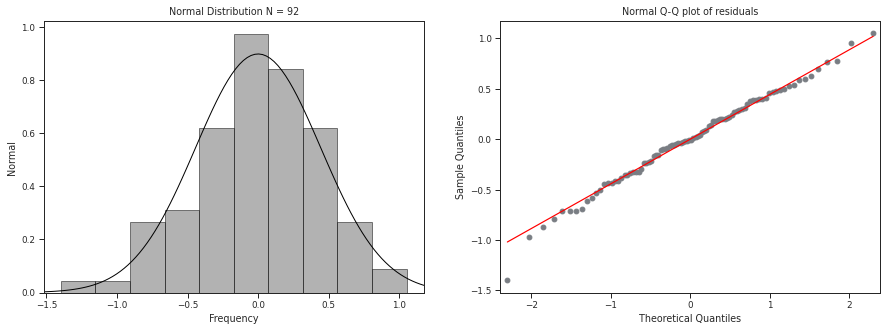

In [74]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

residuals5 = model5.resid
sns.set_context("paper")

mu, std = norm.fit(residuals5)
ax[0].hist(residuals5, bins=10, density=True, alpha=0.6, color='grey', edgecolor='black')
xmin, xmax = ax[0].set_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax[0].plot(x, p, 'black', linewidth=1)
# title "Normal Distribution" + residuals amount
title = "Normal Distribution N = " + str(len(residuals5))

# add x and y labels
ax[0].set_xlabel('Frequency')
ax[0].set_ylabel('Normal')
ax[0].set_title(title)

sm.qqplot(model5.resid, line='s', ax=ax[1])
ax[1].set_title('Normal Q-Q plot of residuals')

plt.show()

## Breusch-Pagan test for heteroscedasticity

In [75]:
bp_test = het_breuschpagan(model5.resid, model5.model.exog)
print(bp_test)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
for i in range(len(bp_test)):
    print(labels[i] + ': ' + str(bp_test[i]))
alpha = 0.05
if bp_test[1] > alpha:
    print('Sample looks homoscedastic (fail to reject H0)')
else:
    print('Sample does not look homoscedastic (reject H0)')

(6.4301828955753875, 0.09245695928523834, 2.2042666988528414, 0.09319987239673917)
Lagrange multiplier statistic: 6.4301828955753875
p-value: 0.09245695928523834
f-value: 2.2042666988528414
f p-value: 0.09319987239673917
Sample looks homoscedastic (fail to reject H0)


## Augmented Dickey-Fuller test for stationarity

In [76]:
result = adfuller(residuals5)

print('ADF Statistic:', result[0])
print('p-value:', result[1])

# If the p-value is less than 0.05, the residuals are considered stationary
if result[1] < 0.05:
  print('The residuals are stationary')
else:
  print('The residuals are not stationary')

ADF Statistic: -3.9414139105938513
p-value: 0.00175034437373409
The residuals are stationary


## Test for multicollinearity

In [77]:
vif = pd.DataFrame()
X = file[['log_diesel','log_bankruptcy2', '12-month']]
X['intercept'] = 1
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif = vif[vif['features']!='intercept']
print(vif)

   VIF Factor         features
0    1.085303       log_diesel
1    1.018906  log_bankruptcy2
2    1.069302         12-month


## No autocorrelation visualisation

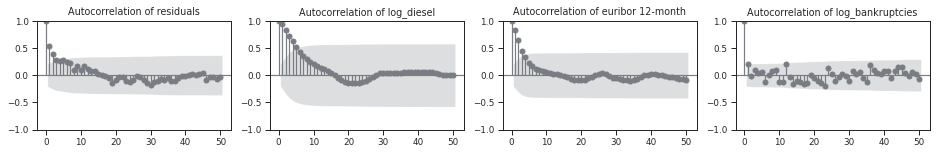

In [78]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 2))
sns.set_context("paper")
plot_acf(residuals5, ax=ax1, lags=50)
ax1.set_title('Autocorrelation of residuals')
plot_acf(file['log_diesel'], ax=ax2, lags=50)
ax2.set_title('Autocorrelation of log_diesel')
plot_acf(file['12-month'], ax=ax3, lags=50)
ax3.set_title('Autocorrelation of euribor 12-month')
plot_acf(file['log_bankruptcy2'], ax=ax4, lags=50)
ax4.set_title('Autocorrelation of log_bankruptcies')

plt.show()

## Zero conditional mean

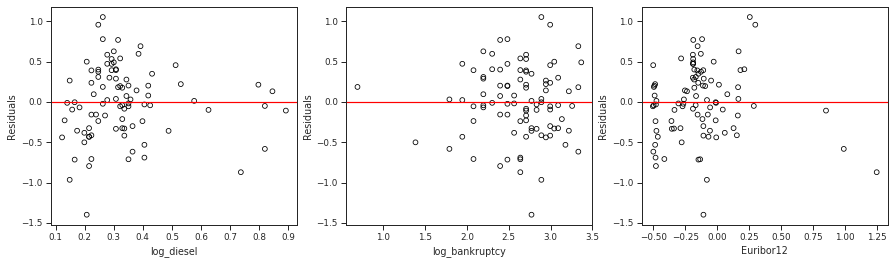

In [79]:
fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
sns.set_context("paper")

ax1.scatter(file['log_diesel'], residuals5, marker='o', facecolors='none', edgecolors='black')
ax1.axhline(y=0, color='r', linestyle='-')
ax1.set_xlabel('log_diesel')
ax1.set_ylabel('Residuals')

ax2.scatter(file['log_bankruptcy2'], residuals5, marker='o', facecolors='none', edgecolors='black' ) # color black
ax2.axhline(y=0, color='r', linestyle='-')
ax2.set_xlabel('log_bankruptcy')
ax2.set_ylabel('Residuals')

ax3.scatter(file['12-month'], residuals5,  marker='o', facecolors='none', edgecolors='black') # color black
ax3.axhline(y=0, color='r', linestyle='-')
ax3.set_xlabel('Euribor12')
ax3.set_ylabel('Residuals')

plt.show()

# Final model: Log_delays ~ log_diesel + euribor_12 + log_bankruptcy (Model 5)

In [80]:
y = file['log_delay']
x = file[['log_diesel', '12-month', 'log_bankruptcy2']]
x = sm.add_constant(x)
model5 = sm.OLS(y, x).fit()
predictions = model5.predict(x)
print_model = model5.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              log_delay   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     17.73
Date:                Sun, 01 Jan 2023   Prob (F-statistic):           4.36e-09
Time:                        14:11:32   Log-Likelihood:                -55.782
No. Observations:                  92   AIC:                             119.6
Df Residuals:                      88   BIC:                             129.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.1749      0.298     

Based on the results of the time series regression analysis, the following is concluded from the hypotheses:

##### Hypothesis 1: 
- The null hypothesis (H0: An increase in diesel prices may lead to an increase in payment delays) is rejected in favor of the alternative hypothesis (H1: An increase in diesel prices may lead to a decrease in payment delays).

##### Hypothesis 2: 
- The null hypothesis (H0: An increase in Euribor's 12-month interest rates may lead to an increase in payment delays) has not been rejected with high confidence. This means that there is no strong evidence to support the alternative hypothesis.

##### Hypothesis 3: 
- The null hypothesis (H0: An increase in bankruptcies within the transportation and warehousing industry may lead to an increase in payment delays) has not been rejected with high confidence.